# Analyze simulated library of codon variants
Simulate a deep mutational scanning experiment on a "plausible" data set of
barcoded codon variants, then analyzes the simulated experiment.

## Setup for analysis

Import Python modules / packages:

In [1]:
import itertools
import random
import tempfile
import warnings

from IPython.display import display, Image

import pandas as pd

from plotnine import *

import scipy

from dms_variants.codonvarianttable import CodonVariantTable
from dms_variants.constants import (CBPALETTE,
                                    CODONS_NOSTOP,
                                    )
import dms_variants.plotnine_themes
from dms_variants.simulate import (simulateSampleCounts,
                                   simulate_CodonVariantTable,
                                   SigmoidPhenotypeSimulator,
                                   )

Set parameters that define the simulated data:

In [2]:
seed = 1  # random number seed
genelength = 50  # gene length in codons
libs = ['lib_1', 'lib_2']  # distinct libraries of gene
variants_per_lib = 500 * genelength  # variants per library
avgmuts = 2.0  # average codon mutations per variant
bclen = 16  # length of nucleotide barcode for each variant
variant_error_rate = 0.05  # rate at which variant mis-called
depth = 200 * variants_per_lib  # per-sample sequencing depth
lib_uniformity = 5  # uniformity of library pre-selection
noise = 0.02  # non-statistical noise in selections
bottlenecks = {  # bottlenecks from pre- to post-selection
        'tight_bottle': variants_per_lib * 5,
        'loose_bottle': variants_per_lib * 100,
        }

Seed random number generator for reproducible output:

In [3]:
random.seed(seed)

Set pandas display options to show large chunks of Data Frames in this
example:

In [4]:
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 500)

Hide warnings that clutter output:

In [5]:
warnings.simplefilter('ignore')

Set the gray grid [plotnine theme](https://plotnine.readthedocs.io/en/stable/generated/plotnine.themes.theme.html?highlight=themes) defined in [dms_variants.plotnine_themes](https://jbloomlab.github.io/dms_variants/dms_variants.plotnine_themes.html) as this gives a nice appearance for the plots:

In [6]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

## Simulate library of variants
Simulate wildtype gene sequence:

In [7]:
geneseq = ''.join(random.choices(CODONS_NOSTOP, k=genelength))
print(f"Wildtype gene of {genelength} codons:\n{geneseq}")

Wildtype gene of 50 codons:
AGATCCGTGATTCTGCGTGCTTACACCAACTCACGGGTGAAACGTGTAATCTTATGCAACAACGACTTACCTATCCGCAACATCCGGCTGATGATGATCCTACACAACTCCGACGCTAGTTTTTCGACTCCAGTAGGTTTACGCTCAGGA


Generate a
[CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable)
using
[simulate_CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.simulate_CodonVariantTable)
function:

In [8]:
variants = simulate_CodonVariantTable(
                geneseq=geneseq,
                bclen=bclen,
                library_specs={lib: {'avgmuts': avgmuts,
                                     'nvariants': variants_per_lib}
                               for lib in libs},
                seed=seed,
                )

We can get basic information about the [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable), such as the sites,
wildtype codons, and wildtype amino acids.
Below we do this for the first few
sites:

In [9]:
variants.sites[: 5]

[1, 2, 3, 4, 5]

In [10]:
list(variants.codons[r] for r in variants.sites[: 5])

['AGA', 'TCC', 'GTG', 'ATT', 'CTG']

In [11]:
list(variants.aas[r] for r in variants.sites[: 5])

['R', 'S', 'V', 'I', 'L']

A list of the different libraries in the table:

In [12]:
variants.libraries

['lib_1', 'lib_2']

Here is the data frame that contains all of the information on the barcoded
variants (just looking at the first few lines)

In [13]:
variants.barcode_variant_df.head(n=6)

,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
0,lib_1,AAAAAAATTTACGCGA,1,TTA18GTC TTA23TCA TTT41AAC,L18V L23S F41N,3,3
1,lib_1,AAAAAACATAGGAGTA,3,TGC19AAG CGG29TCC,C19K R29S,2,2
2,lib_1,AAAAAAGAGGTTAAAC,1,ATG32TTC,M32F,1,1
3,lib_1,AAAAAAGGCTTATACT,1,TCA11TCG CGG12GGT GGT46AAA,R12G G46K,3,2
4,lib_1,AAAAAATCACTAATAT,3,AGA1ACA CGT15CCG TCC37GCT AGT40TAA TCG42AGC,R1T R15P S37A S40*,5,4
5,lib_1,AAAAACAACGGGCCCC,1,GTA16TGC,V16C,1,1


## Analyze library composition
A [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable)
has methods for summarizing and plotting properties of the barcoded variants.
These methods can be used to analyze the barcoded variants themselves, or to
analyze the frequency (or counts) of variants in the library in samples that
have undergone some type of selection.
So for we have not added counts of the
variants in any specific samples, so we just analyze the composition of the
variant library itself.
This is done by setting `samples=None` in the method
calls below.

Get the number of variants in each library:

In [14]:
variants.n_variants_df(samples=None)

,library,sample,count
0,lib_1,barcoded variants,25000
1,lib_2,barcoded variants,25000
2,all libraries,barcoded variants,50000


Plot distribution of variant call supports, grouping together all variants with support $\ge 8$:

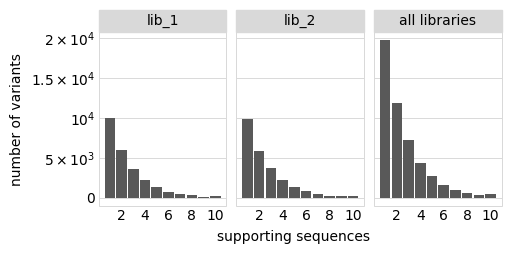

In [15]:
p = variants.plotVariantSupportHistogram(max_support=10)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

Get the set of valid barcodes for each library:

In [16]:
for lib in libs:
    print(f"First few barcodes for library {lib}:")
    print(sorted(variants.valid_barcodes(lib))[ : 3])

First few barcodes for library lib_1:
['AAAAAAATTTACGCGA', 'AAAAAACATAGGAGTA', 'AAAAAAGAGGTTAAAC']
First few barcodes for library lib_2:
['AAAAAAAGCATGAAAG', 'AAAAAAATCGTCACCA', 'AAAAAACATCCGATCC']


Plot the number of amino-acid mutations per variant:

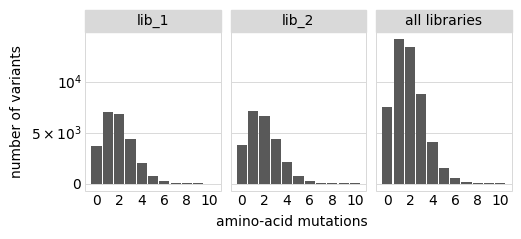

In [17]:
p = variants.plotNumMutsHistogram('aa', samples=None)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

Number of codon mutations per variant:

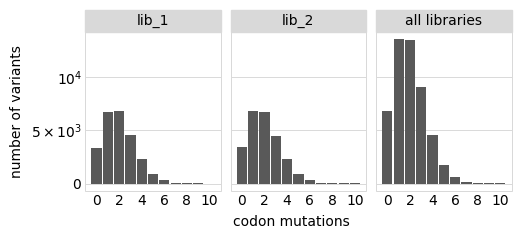

In [18]:
p = variants.plotNumMutsHistogram('codon', samples=None)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

Average number of codon mutations per variant of each type of codon mutation.
We make these plots for:
 1. Just single-mutant and wildtype variants
 2. For all variants

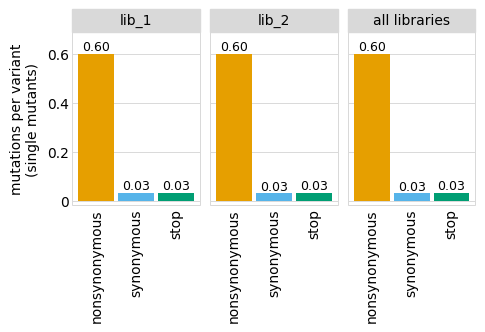

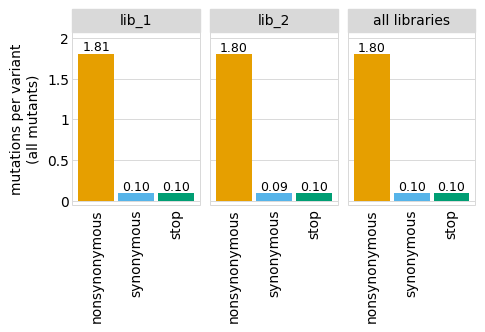

In [19]:
for mut_type in ['single', 'all']:
    p = variants.plotNumCodonMutsByType(mut_type, samples=None)
    p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
    _ = p.draw()

Here are the numerical data in the plots above:

In [20]:
variants.numCodonMutsByType('single', samples=None)

,library,sample,mutation_type,num_muts_count,count,number
0,lib_1,barcoded variants,nonsynonymous,6053,10081,0.600436
1,lib_1,barcoded variants,synonymous,331,10081,0.032834
2,lib_1,barcoded variants,stop,332,10081,0.032933
3,lib_2,barcoded variants,nonsynonymous,6160,10264,0.600156
4,lib_2,barcoded variants,synonymous,324,10264,0.031567
5,lib_2,barcoded variants,stop,336,10264,0.032736
6,all libraries,barcoded variants,nonsynonymous,12213,20345,0.600295
7,all libraries,barcoded variants,synonymous,655,20345,0.032195
8,all libraries,barcoded variants,stop,668,20345,0.032834


In [21]:
variants.numCodonMutsByType('all', samples=None)

,library,sample,mutation_type,num_muts_count,count,number
0,lib_1,barcoded variants,nonsynonymous,45156,25000,1.80624
1,lib_1,barcoded variants,synonymous,2414,25000,0.09656
2,lib_1,barcoded variants,stop,2416,25000,0.09664
3,lib_2,barcoded variants,nonsynonymous,45027,25000,1.80108
4,lib_2,barcoded variants,synonymous,2365,25000,0.09460
5,lib_2,barcoded variants,stop,2431,25000,0.09724
6,all libraries,barcoded variants,nonsynonymous,90183,50000,1.80366
7,all libraries,barcoded variants,synonymous,4779,50000,0.09558
8,all libraries,barcoded variants,stop,4847,50000,0.09694


Examine how well mutations are sampled in the library by looking at the
fraction
of mutations seen <= some number of times.
Here we do that for codon and amino-
acid mutations, making separate plots for single mutants and all mutants:

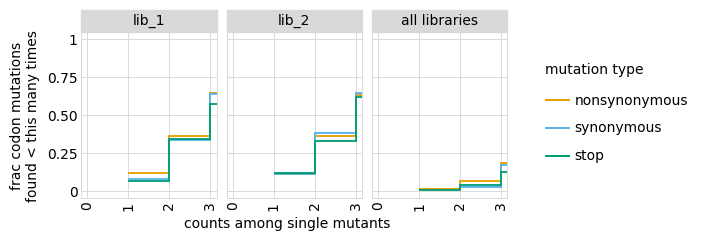

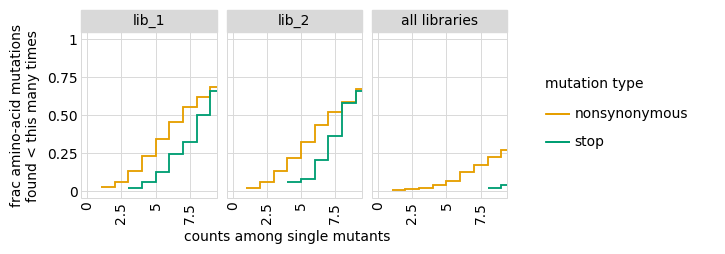

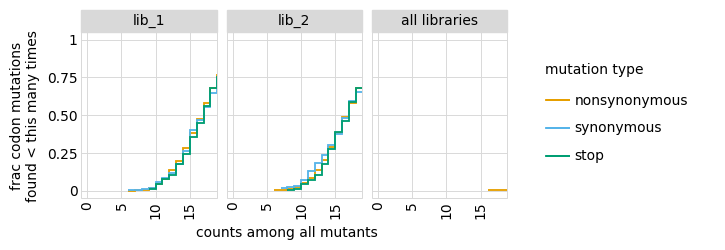

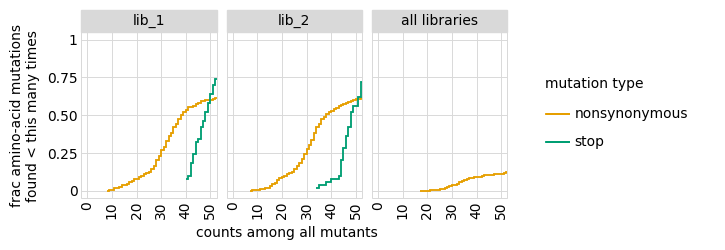

In [22]:
for variant_type, mut_type in itertools.product(
            ['single', 'all'],
            ['codon', 'aa']):
    p = variants.plotCumulMutCoverage(variant_type,
                                      mut_type,
                                      samples=None)
    _ = p.draw()

We can also get the numerical information plotted above (here for single mutants
only):

In [23]:
variants.mutCounts('single', 'aa', samples=None).head(n=5)

,library,sample,mutation,count,mutation_type,site
0,lib_1,barcoded variants,V16L,25,nonsynonymous,16
1,lib_1,barcoded variants,G50R,24,nonsynonymous,50
2,lib_1,barcoded variants,Y8L,24,nonsynonymous,8
3,lib_1,barcoded variants,A7L,23,nonsynonymous,7
4,lib_1,barcoded variants,D22R,21,nonsynonymous,22


Here are the frequencies of mutations along the gene, looking both at single
mutants and all mutants:

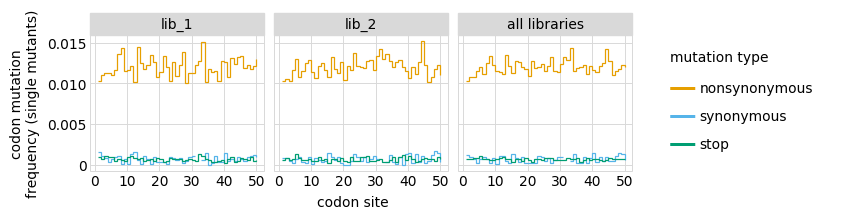

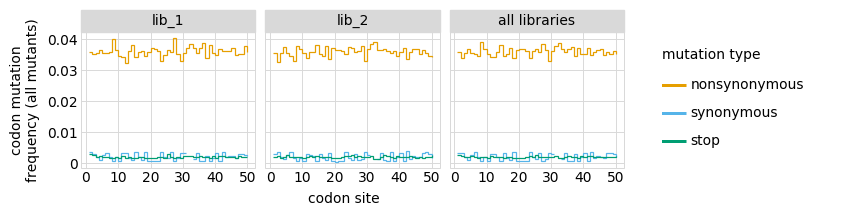

In [24]:
for variant_type in ['single', 'all']:
    p = variants.plotMutFreqs(variant_type,
                              'codon', 
                              samples=None)
    _ = p.draw()

We can also look at mutation frequencies in a heat-map form:

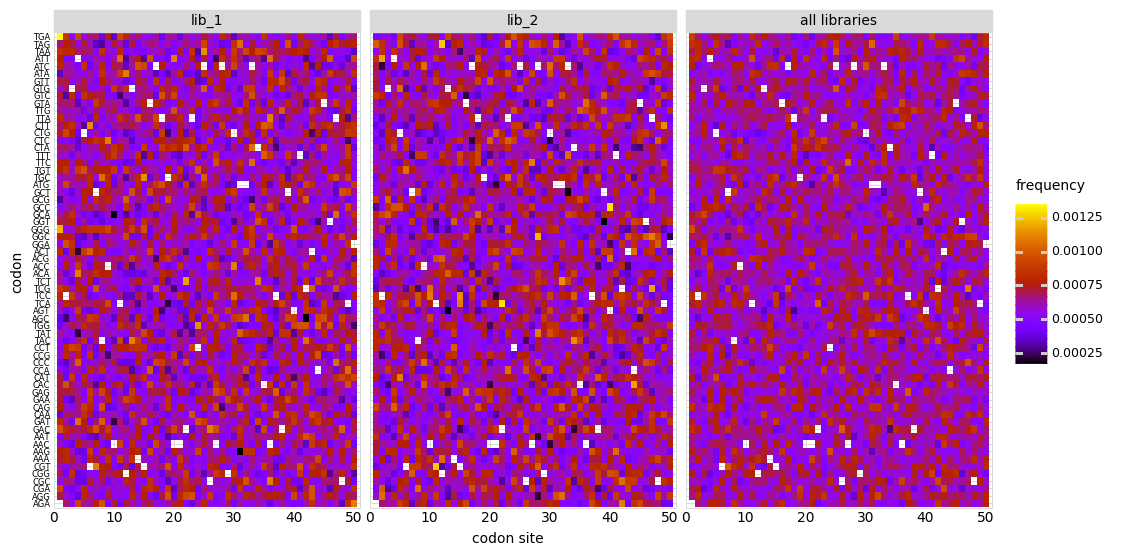

In [25]:
p = variants.plotMutHeatmap('all', 'codon', samples=None)
_ = p.draw()

And we can do the same for amino-acid mutations:

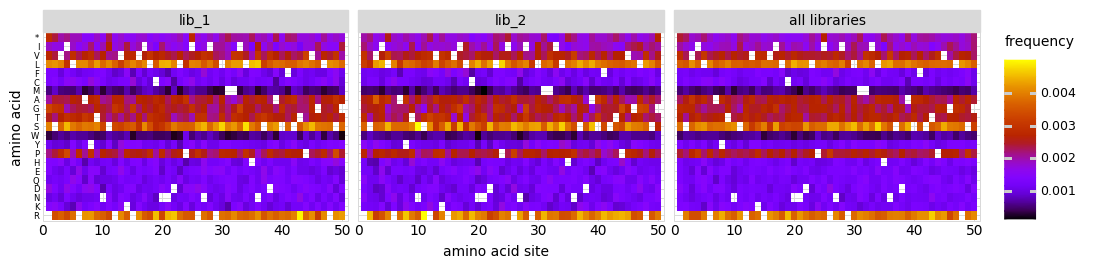

In [26]:
p = variants.plotMutHeatmap('all', 'aa', samples=None)
_ = p.draw()

## Simulate counts for samples
An experiment involves subjecting the library to
different selections and looking at how the frequencies of the variants changes
by using sequencing to count the barcodes in each condition.

Here, we simulate
an experiment by simulating variant counts for samples that have undergone
various selections.

For these simulations, we first need to define a
"phenotype" for each variant.
The phenotype represents how much the frequency of
the variant is expected to increase or decrease after selection.

### Define phenotype function
First, we define a “phenotype” function. We will
do this using a
[SigmoidPhenotypeSimulator](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.SigmoidPhenotypeSimulator),
which follow the "global epistasis" concepts of [Otwinoski et
al](https://doi.org/10.1073/pnas.1804015115) and [Sailer and
Harms](https://doi.org/10.1534/genetics.116.195214) to define the phenotype in
two steps: an underlying latent phenotype that mutations affect additively, and
then an observed phenotype that is a non-linear (in this case, sigmoidal)
function of the latent phenotype.

First, we initialize the simulator:

In [27]:
phenosimulator = SigmoidPhenotypeSimulator(geneseq,
                                           seed=seed)

Plot the relationship of the latent and observed phenotypes, with a dashed
vertical line indicating the wildtype phenotype:

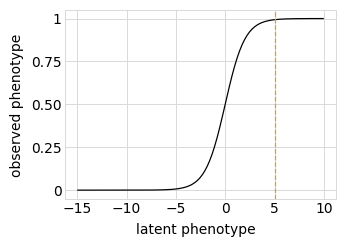

In [28]:
p = phenosimulator.plotLatentVsObserved()
_ = p.draw()

Plot the latent and observed phenotypes of all single amino-acid mutants, with a
dashed vertical line indicating the wildtype phenotype:

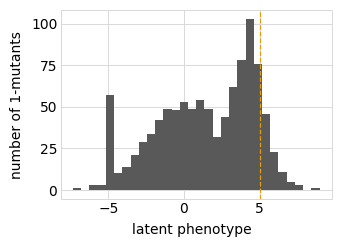

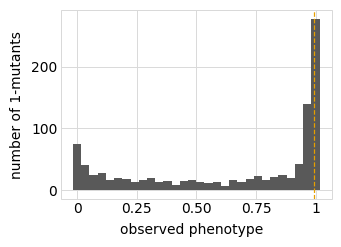

In [29]:
for phenotype in ['latent', 'observed']:
    p = phenosimulator.plotMutsHistogram(phenotype)
    _ = p.draw()

### Simulate variant counts
Now we use
[simulateSampleCounts](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.simulateSampleCounts)
to simulate counts of variants when selection on each variant is proportional to
its observed phenotype.
In these simulations, we can fine-tune the simulations
to reflect real experiments, such as by setting the error-rate in variant
calling, bottlenecks when going from the pre- to post-selection samples, and
non-uniformity in library composition.

Here we simulate using several
bottlenecks in the library going from the pre- to post-selection samples, since
in real experiments this seems to be the biggest source of noise / error:

In [30]:
counts = simulateSampleCounts(
            variants=variants,
            phenotype_func=phenosimulator.observedPhenotype,
            variant_error_rate=variant_error_rate,
            pre_sample={'total_count': depth,
                        'uniformity': lib_uniformity},
            pre_sample_name='pre-selection',
            post_samples={name: {'noise': noise,
                                 'total_count': depth,
                                 'bottleneck': bottle}
                          for name, bottle in bottlenecks.items()},
            seed=seed,
            )

First few lines of the data frame with the simulated counts:

In [31]:
counts.head(n=5)

,library,barcode,sample,count
0,lib_1,AAAAAAATTTACGCGA,pre-selection,112
1,lib_1,AAAAAACATAGGAGTA,pre-selection,363
2,lib_1,AAAAAAGAGGTTAAAC,pre-selection,142
3,lib_1,AAAAAAGGCTTATACT,pre-selection,60
4,lib_1,AAAAAATCACTAATAT,pre-selection,219


### Add counts to variant table
Now add the simulated counts for each library /
sample to the
[CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable):

In [32]:
variants.add_sample_counts_df(counts)

We can confirm that we have added the expected number of counts per library /
sample:

In [33]:
variants.n_variants_df()

,library,sample,count
0,lib_1,pre-selection,5000000
1,lib_1,loose_bottle,5000000
2,lib_1,tight_bottle,5000000
3,lib_2,pre-selection,5000000
4,lib_2,loose_bottle,5000000
5,lib_2,tight_bottle,5000000
6,all libraries,pre-selection,10000000
7,all libraries,loose_bottle,10000000
8,all libraries,tight_bottle,10000000


## Analyze sample variant counts
A
[CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable)
has methods for summarizing and plotting the variant counts for different
samples.
These methods are mostly the same as we used above to analyze the
variant composition of the libraries themselves, but now we set `samples` to the
samples that we want to analyze (typically 'all').
Therefore, rather than each
variant always counting once, each variant is counted in each sample in
proportion to how many counts it has.

In the rawest form, we can directly
access a data frame giving the counts of each variant in each sample:

In [34]:
variants.variant_count_df.head(n=5)

,barcode,count,library,sample,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
0,TCATTCGTAACAAAAA,879,lib_1,pre-selection,2,AAC21CAC,N21H,1,1
1,TCTGAGCAGTCGAGTG,813,lib_1,pre-selection,2,GTG3GCC AAC20GCG,V3A N20A,2,2
2,ATCAGGTAGAAGGCGA,765,lib_1,pre-selection,2,CGG12TTC GTG13AAC,R12F V13N,2,2
3,ATGTAGAGATACTCGG,755,lib_1,pre-selection,2,AAC10TGT,N10C,1,1
4,GGCATCAACATGCCTA,724,lib_1,pre-selection,6,AGA1GTG CGG12GGC CTA34GTG,R1V R12G L34V,3,3


First, we get the **average** number of counts per variant:

In [35]:
variants.avgCountsPerVariant()

,library,sample,avg_counts_per_variant
0,lib_1,pre-selection,200
1,lib_1,loose_bottle,200
2,lib_1,tight_bottle,200
3,lib_2,pre-selection,200
4,lib_2,loose_bottle,200
5,lib_2,tight_bottle,200
6,all libraries,pre-selection,200
7,all libraries,loose_bottle,200
8,all libraries,tight_bottle,200


We also plot the average counts per variant:

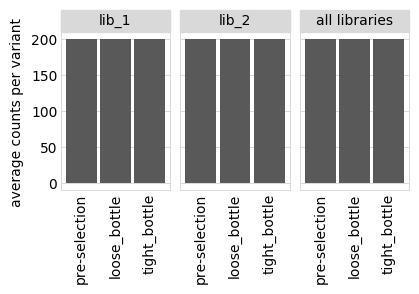

In [36]:
p = variants.plotAvgCountsPerVariant()
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

Plot the number of counts for each variant in each sample. 
The horizontal
dashed line shows the total number of variants. 
The plot shows that all
variants are well-sampled in the pre-selection libraries, but that post-
selection some variants are sampled more or less.
This is expected since
selection will decrease and increase the frequency of variants:

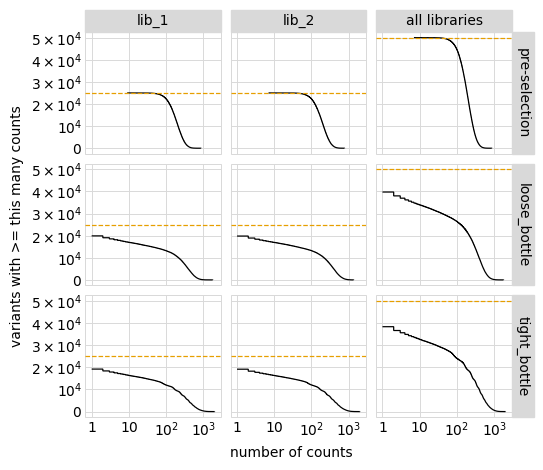

In [37]:
p = variants.plotCumulVariantCounts()
_ = p.draw()

Here is the distribution of the number of mutations per variant in each sample.
As expected, mutations go down after selection:

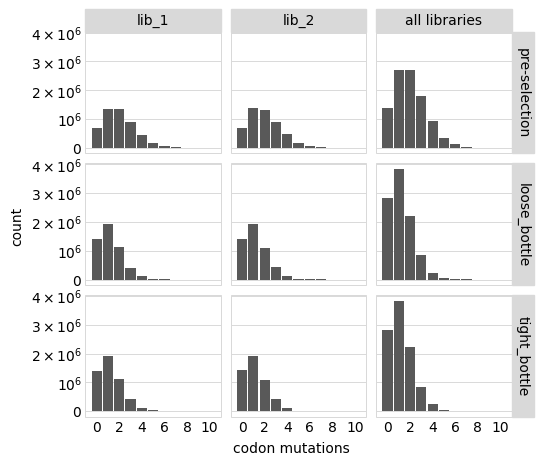

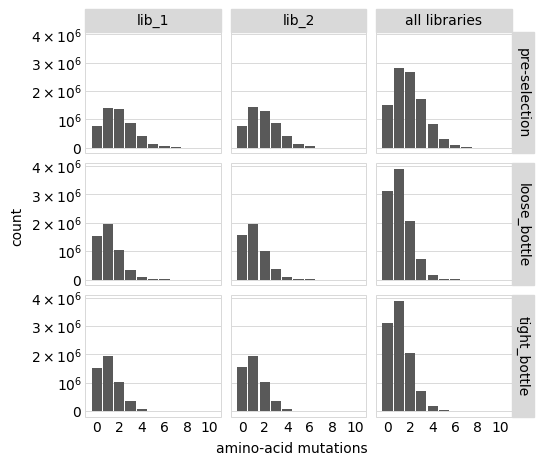

In [38]:
for mut_type in ['codon', 'aa']:
    p = variants.plotNumMutsHistogram(mut_type=mut_type)
    p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
    _ = p.draw()

Here is the average number of mutations per variant among just single mutants
(and wildtype) and among all variants:

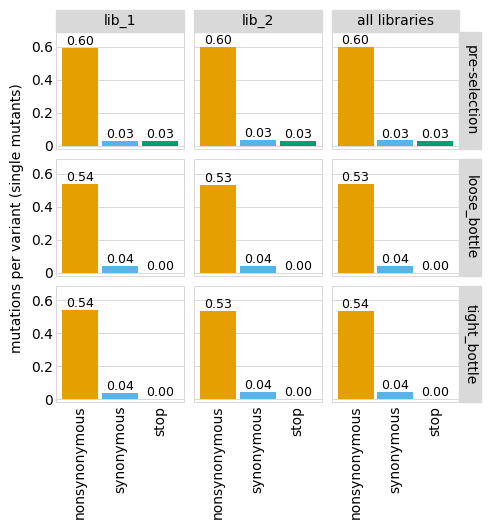

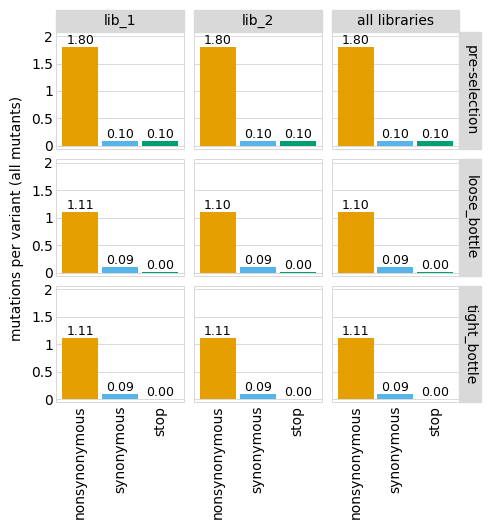

In [39]:
for variant_type in ['single', 'all']:
    p = variants.plotNumCodonMutsByType(variant_type)
    p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
    _ = p.draw()

Here are the numerical data plotted above:

In [40]:
variants.numCodonMutsByType('single')

,library,sample,mutation_type,num_muts_count,count,number
0,lib_1,pre-selection,nonsynonymous,1207567,2024314,0.596531
1,lib_1,pre-selection,synonymous,65682,2024314,0.032447
2,lib_1,pre-selection,stop,65466,2024314,0.032340
3,lib_1,loose_bottle,nonsynonymous,1778740,3319458,0.535853
4,lib_1,loose_bottle,synonymous,134092,3319458,0.040396
5,lib_1,loose_bottle,stop,858,3319458,0.000258
6,lib_1,tight_bottle,nonsynonymous,1786328,3314628,0.538923
7,lib_1,tight_bottle,synonymous,133001,3314628,0.040125
8,lib_1,tight_bottle,stop,848,3314628,0.000256
9,lib_2,pre-selection,nonsynonymous,1236352,2062781,0.599362


In [41]:
variants.numCodonMutsByType('all')

,library,sample,mutation_type,num_muts_count,count,number
0,lib_1,pre-selection,nonsynonymous,8999610,5000000,1.799922
1,lib_1,pre-selection,synonymous,481135,5000000,0.096227
2,lib_1,pre-selection,stop,481832,5000000,0.096366
3,lib_1,loose_bottle,nonsynonymous,5539050,5000000,1.107810
4,lib_1,loose_bottle,synonymous,466897,5000000,0.093379
5,lib_1,loose_bottle,stop,11298,5000000,0.002260
6,lib_1,tight_bottle,nonsynonymous,5563712,5000000,1.112742
7,lib_1,tight_bottle,synonymous,471130,5000000,0.094226
8,lib_1,tight_bottle,stop,11531,5000000,0.002306
9,lib_2,pre-selection,nonsynonymous,8989862,5000000,1.797972


Here are mutation frequencies as a function of primary sequence:

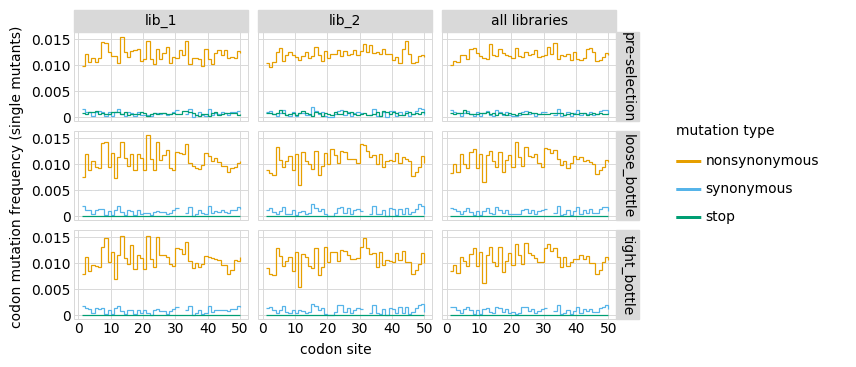

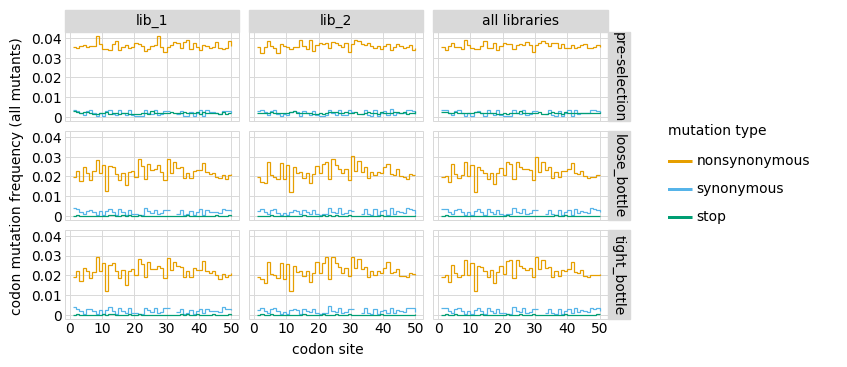

In [42]:
for variant_type in ['single', 'all']:
    p = variants.plotMutFreqs(variant_type=variant_type,
                              mut_type='codon')
    _ = p.draw()

We can plot how thoroughly mutations are sampled in each sample:

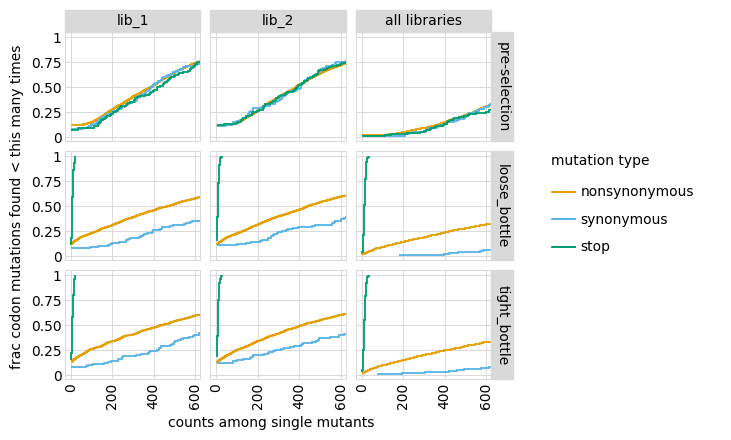

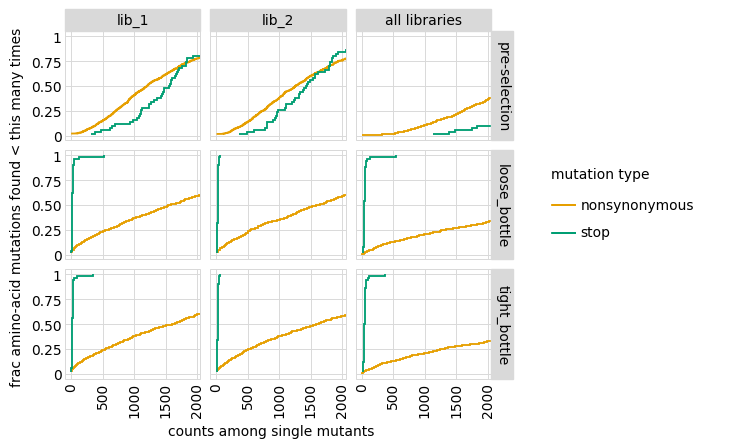

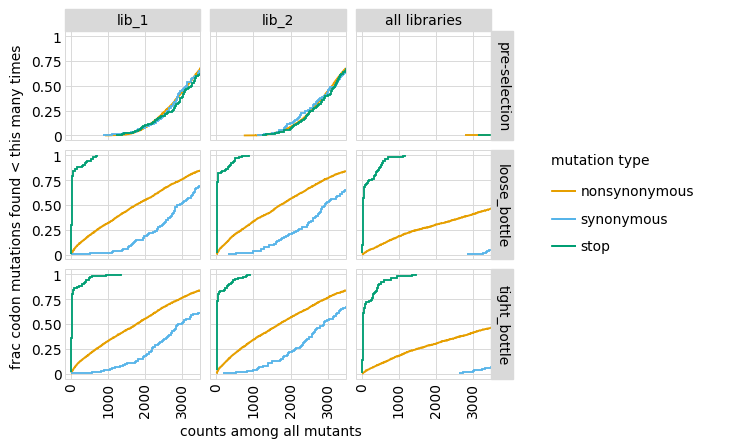

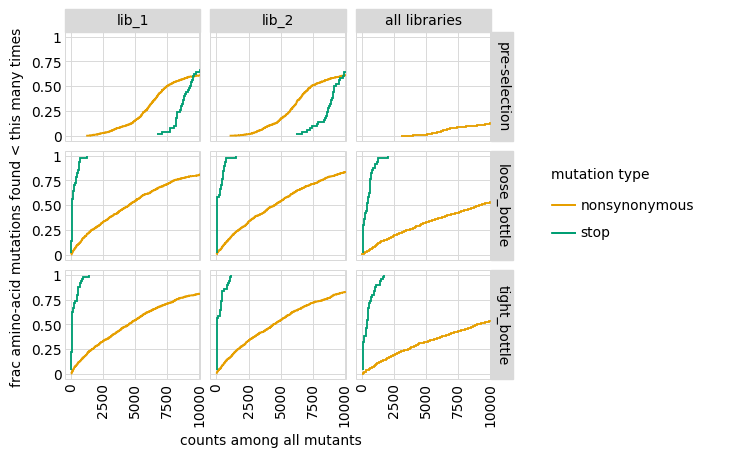

In [43]:
for variant_type, mut_type in itertools.product(
            ['single', 'all'],
            ['codon', 'aa']):
    p = variants.plotCumulMutCoverage(variant_type=variant_type,
                                      mut_type=mut_type)
    _ = p.draw()

## Functional scores for variants
The
[CodonVariantTable.func_scores](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable.func_scores)
method calculates a functional score for each variant based on its change in
frequency from pre- to post-selection.

In order to calculate these scores, we
need to pair each
post-selection sample with a pre-selection one.
In this case,
the pre-selection sample is named 'pre-selection' for all post-selection
samples:

In [44]:
func_scores = variants.func_scores('pre-selection')

We can see that the resulting data frame has a functional score (and its
variance) for each barcoded variant:

In [45]:
func_scores.head(n=5)

,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,codon_substitutions,n_codon_substitutions,aa_substitutions,n_aa_substitutions
0,lib_1,pre-selection,loose_bottle,TCATTCGTAACAAAAA,0.009690,0.003517,879,1815,685599,1405768,0.5,AAC21CAC,1,N21H,1
1,lib_1,pre-selection,loose_bottle,TCTGAGCAGTCGAGTG,-6.212067,0.095068,813,22,685599,1405768,0.5,GTG3GCC AAC20GCG,2,V3A N20A,2
2,lib_1,pre-selection,loose_bottle,ATCAGGTAGAAGGCGA,0.113016,0.003950,765,1697,685599,1405768,0.5,CGG12TTC GTG13AAC,2,R12F V13N,2
3,lib_1,pre-selection,loose_bottle,ATGTAGAGATACTCGG,-1.753288,0.007289,755,459,685599,1405768,0.5,AAC10TGT,1,N10C,1
4,lib_1,pre-selection,loose_bottle,GGCATCAACATGCCTA,0.117426,0.004169,724,1611,685599,1405768,0.5,AGA1GTG CGG12GGC CTA34GTG,3,R1V R12G L34V,3


In [46]:
func_scores.tail(n=5)

,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,codon_substitutions,n_codon_substitutions,aa_substitutions,n_aa_substitutions
199995,all libraries,pre-selection,tight_bottle,lib_2-TGTCAACGAGATCGGG,-6.236686,4.275247,18,0,1379087,2810733,0.5,TTA18CTT CGG29CAC ACT43GGA TCA49ACC,4,R29H T43G S49T,3
199996,all libraries,pre-selection,tight_bottle,lib_2-TCGATCTGGAAGGTAT,-6.156516,4.281676,17,0,1379087,2810733,0.5,CGT6TCC AAC27AAT GAC38CTT,3,R6S D38L,2
199997,all libraries,pre-selection,tight_bottle,lib_2-CTCCCTCGAGGATCCA,-3.174074,0.728961,15,3,1379087,2810733,0.5,CGT15GGC,1,R15G,1
199998,all libraries,pre-selection,tight_bottle,lib_2-TCCATCGACGTAGTTA,-5.782120,4.316916,13,0,1379087,2810733,0.5,AGA1CGG ATC17AAA TCC37AGA TCG42TAA,4,I17K S37R S42*,3
199999,all libraries,pre-selection,tight_bottle,lib_2-TCGGGGGGCAGATGGC,2.184818,0.307466,7,69,1379087,2810733,0.5,ATC17AGT AAC20AGC,2,I17S N20S,2


We can also get scores for just some libraries:

In [47]:
variants.func_scores('pre-selection', libraries='all_only').head(n=5)

,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,codon_substitutions,n_codon_substitutions,aa_substitutions,n_aa_substitutions
0,all libraries,pre-selection,loose_bottle,lib_1-TCATTCGTAACAAAAA,0.011314,0.003515,879,1815,1379087.0,2824530.0,0.5,AAC21CAC,1,N21H,1
1,all libraries,pre-selection,loose_bottle,lib_1-TCTGAGCAGTCGAGTG,-6.210443,0.095066,813,22,1379087.0,2824530.0,0.5,GTG3GCC AAC20GCG,2,V3A N20A,2
2,all libraries,pre-selection,loose_bottle,lib_1-ATCAGGTAGAAGGCGA,0.114640,0.003947,765,1697,1379087.0,2824530.0,0.5,CGG12TTC GTG13AAC,2,R12F V13N,2
3,all libraries,pre-selection,loose_bottle,lib_1-ATGTAGAGATACTCGG,-1.751664,0.007287,755,459,1379087.0,2824530.0,0.5,AAC10TGT,1,N10C,1
4,all libraries,pre-selection,loose_bottle,lib_1-GGCATCAACATGCCTA,0.119050,0.004167,724,1611,1379087.0,2824530.0,0.5,AGA1GTG CGG12GGC CTA34GTG,3,R1V R12G L34V,3


In [48]:
variants.func_scores('pre-selection', libraries=['lib_2']).head(n=5)

,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,codon_substitutions,n_codon_substitutions,aa_substitutions,n_aa_substitutions
0,lib_2,pre-selection,loose_bottle,AAAACCAGATCGCACC,-0.692235,0.004771,781,989,693488.0,1418762.0,0.5,CGC48GCC,1,R48A,1
1,lib_2,pre-selection,loose_bottle,TACGGTGGTGGTATGA,-6.509811,0.121610,779,17,693488.0,1418762.0,0.5,GTG3GCA,1,V3A,1
2,lib_2,pre-selection,loose_bottle,AACGGTTCGTTATGGT,-0.595851,0.004744,763,1033,693488.0,1418762.0,0.5,ACC9TTA CAC35ACT GCT39CGT TTA47TTG,4,T9L H35T A39R,3
3,lib_2,pre-selection,loose_bottle,GGGAATTTGCCCCAAG,-0.113867,0.004385,726,1373,693488.0,1418762.0,0.5,TGC19CGA,1,C19R,1
4,lib_2,pre-selection,loose_bottle,TGCGGGCTACACGAAC,-7.448058,0.247740,725,8,693488.0,1418762.0,0.5,GTA16TGA,1,V16*,1


We can also calculate functional scores at the level of amino-acid or codon
substitutions rather than at the level of variants. 
This calculation groups all
variants with the same substitutions before calculating the functional score.
Here are scores grouping by amino-acid substitutions; we also set
`syn_as_wt=True` to include variants with only synonymous mutations in the
counts of wild type in this case:

In [49]:
aa_func_scores = variants.func_scores('pre-selection',
                                      by='aa_substitutions',
                                      syn_as_wt=True)
aa_func_scores.head(n=5)

,library,pre_sample,post_sample,aa_substitutions,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_aa_substitutions
0,lib_1,pre-selection,loose_bottle,N21H,-0.040468,0.001209,2593,5169,753999,1545665,0.5,1
1,lib_1,pre-selection,loose_bottle,V3A N20A,-6.211738,0.095068,813,22,753999,1545665,0.5,2
2,lib_1,pre-selection,loose_bottle,R12F V13N,0.113345,0.003949,765,1697,753999,1545665,0.5,2
3,lib_1,pre-selection,loose_bottle,N10C,-1.680831,0.004675,1142,730,753999,1545665,0.5,1
4,lib_1,pre-selection,loose_bottle,R1V R12G L34V,0.117754,0.004169,724,1611,753999,1545665,0.5,3


In [50]:
aa_func_scores.tail(n=5)

,library,pre_sample,post_sample,aa_substitutions,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_aa_substitutions
118619,all libraries,pre-selection,tight_bottle,R1V L5P A7R G50V,-6.237585,4.275246,18,0,1519515,3098872,0.5,4
118620,all libraries,pre-selection,tight_bottle,R29H T43G S49T,-6.237585,4.275246,18,0,1519515,3098872,0.5,3
118621,all libraries,pre-selection,tight_bottle,R6S D38L,-6.157415,4.281675,17,0,1519515,3098872,0.5,2
118622,all libraries,pre-selection,tight_bottle,I17K S37R S42*,-5.783020,4.316915,13,0,1519515,3098872,0.5,3
118623,all libraries,pre-selection,tight_bottle,I17S N20S,2.183918,0.307466,7,69,1519515,3098872,0.5,2


We can plot the distribution of the functional scores for variants.
These plots
are most informative if we classify variants
by the “types” of mutations they
have, which we do here using the
[CodonVariantTable.classifyVariants](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable.classifyVariants)
method, which adds a  column called `variant_class` to the data frame:

In [51]:
func_scores = CodonVariantTable.classifyVariants(func_scores)

(func_scores
 .head(n=5)
 [['codon_substitutions','aa_substitutions', 'variant_class']]
 )

,codon_substitutions,aa_substitutions,variant_class
0,AAC21CAC,N21H,1 nonsynonymous
1,GTG3GCC AAC20GCG,V3A N20A,>1 nonsynonymous
2,CGG12TTC GTG13AAC,R12F V13N,>1 nonsynonymous
3,AAC10TGT,N10C,1 nonsynonymous
4,AGA1GTG CGG12GGC CTA34GTG,R1V R12G L34V,>1 nonsynonymous


Now we use [plotnine](https://plotnine.readthedocs.io) to plot the distributions
of scores in ggplot2-like syntax, coloring by the variant class.
This plot shows
the expected behavior for different variant classes; for instance, stop codon
variants tend to have low scores and synonymous variants tend to have wildtype-
like (near 0) scores:

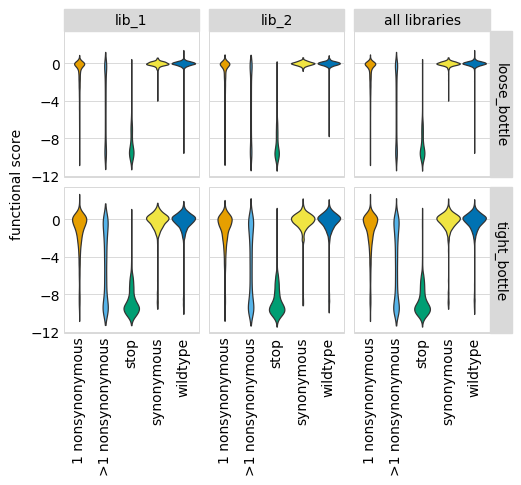

In [52]:
p = (
    ggplot(func_scores, aes('variant_class', 'func_score')) +
    geom_violin(aes(fill='variant_class')) +
    ylab('functional score') +
    xlab('') +
    facet_grid('post_sample ~ library') +
    theme(figure_size=(2.75 * len(libs), 
                       2 * len(bottlenecks)),
          axis_text_x=element_text(angle=90),
          panel_grid_major_x=element_blank(),  # no vertical grid lines
          ) +
    scale_fill_manual(values=CBPALETTE[1 :], guide=False)
    )
_ = p.draw()

## Functional scores vs phenotype
Since we simulated the data, we know the
*true* observed phenotype for each variant. 
We can therefore correlate the true
phenotype with the observed functional score. 
Given how the functional scores
were computed, we expect the $\log_2$ of the true phenotype to equal the
observed functional score.

Add the true phenotypes to the data frame of
functional scores:

In [53]:
func_scores = (
    func_scores
    .assign(observed_phenotype=lambda x: x.apply(
                phenosimulator.observedPhenotype, axis=1),
            latent_phenotype=lambda x: x.apply(
                phenosimulator.latentPhenotype, axis=1),
            log_observed_phenotype=lambda x: scipy.log(
                x.observed_phenotype) / scipy.log(2),
            )
    )

Plot the correlation of the true phenotype and functional score from the
simulated experiment.
The plot below shows that the correlations are pretty good
until we get to very low-fitness phenotypes, although some points are outliers
(probably due to one of the simulated sources of experimental noise):

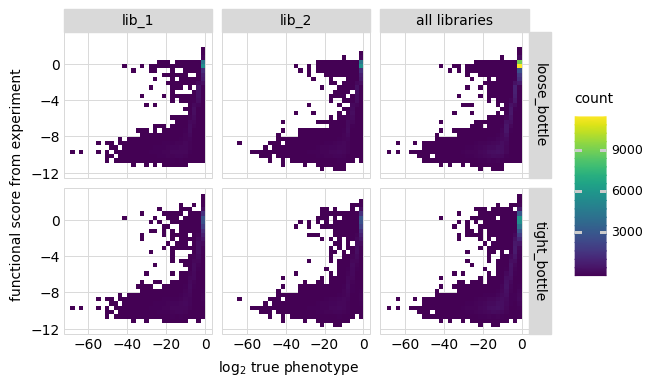

In [54]:
p = (
    ggplot(func_scores,
           aes('log_observed_phenotype', 'func_score')) +
    geom_bin2d() +
    facet_grid('post_sample ~ library') +
    theme(figure_size=(2 * len(libs) + 2,
                       2 * len(bottlenecks))) +
    xlab('$\log_2$ true phenotype') +
    ylab('functional score from experiment')
    )
_ = p.draw()

Here are the Pearson correlations between the true and measured phenotypes:

In [55]:
corr = (
    func_scores
     .groupby(['library', 'post_sample'])
     .apply(lambda x: x['func_score'].corr(
                      x['log_observed_phenotype'],
                      method='pearson'))
     .rename('Pearson correlation')
     .reset_index()
     .pivot_table(index='post_sample',
                  values='Pearson correlation',
                  columns='library')
     )
corr.round(3)

library,lib_1,lib_2,all libraries
post_sample,,,
loose_bottle,0.848,0.846,0.847
tight_bottle,0.802,0.800,0.801


The poorest correlation of the functional scores with the log observed phenotype
comes at the low end, which may not be very important if we don't care too much
about estimating the exact phenotype of very low-fitness variants.
We can
effectively "collapse" the low end by exponentiating the functional scores to
give the _enrichment_ of a variant in the experiment (we exponentiate with base
2 since that's the base used to calculate the functional scores):

In [56]:
func_scores = (
    func_scores
    .assign(enrichment=lambda x: 2**x['func_score'])
    )

Plot of correlation between observed phenotype and enrichment:

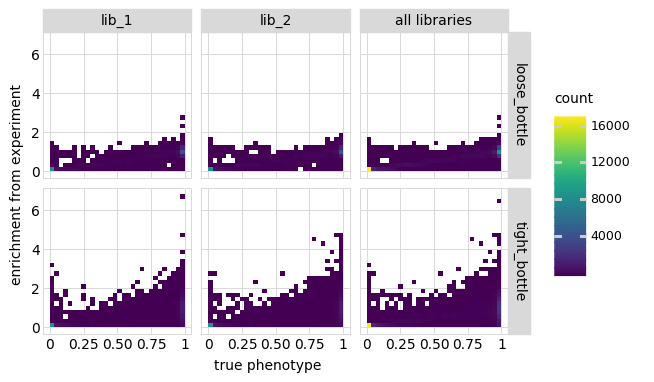

In [57]:
p = (
    ggplot(func_scores,
           aes('observed_phenotype',
               'enrichment')) +
    geom_bin2d() +
    facet_grid('post_sample ~ library') +
    theme(figure_size=(2 * len(libs) + 2,
                       2 * len(bottlenecks))) +
    xlab('true phenotype') +
    ylab('enrichment from experiment')
    )
_ = p.draw()

And the Pearson correlations:

In [58]:
corr = (
    func_scores
     .groupby(['library', 'post_sample'])
     .apply(lambda x: x['enrichment'].corr(
                      x['observed_phenotype'],
                      method='pearson'))
     .rename('Pearson correlation')
     .reset_index()
     .pivot_table(index='post_sample',
                  values='Pearson correlation',
                  columns='library')
     )
corr.round(3)

library,lib_1,lib_2,all libraries
post_sample,,,
loose_bottle,0.956,0.954,0.955
tight_bottle,0.783,0.775,0.779


## Aside: formatting plots
The plots returned by the
[CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable)
above are all [plotnine](https://plotnine.readthedocs.io) ggplot objects.
So you
can format them differently by setting a different [plotnine
theme](https://plotnine.readthedocs.io/en/stable/api.html#themes).

Here we set the default [plotnine](https://plotnine.readthedocs.io) theme, which is like the default used by ggplot2:

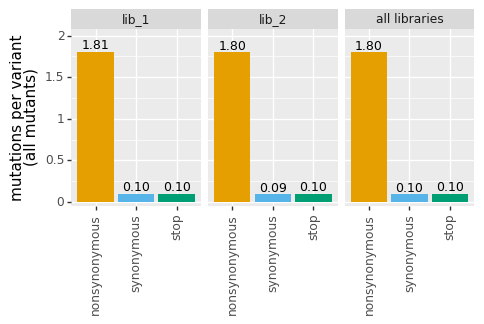

In [59]:
theme_set(theme_gray())
p = variants.plotNumCodonMutsByType('all', samples=None)
_ = p.draw()

Here is another theme:

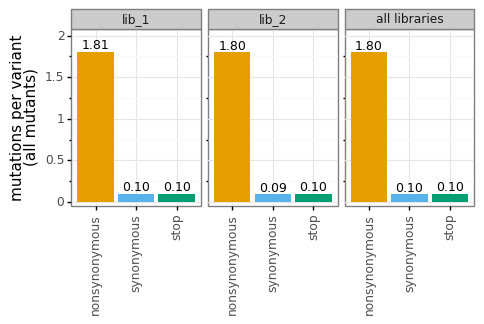

In [60]:
theme_set(theme_bw())
p = variants.plotNumCodonMutsByType('all', samples=None)
_ = p.draw()

Or more silly:

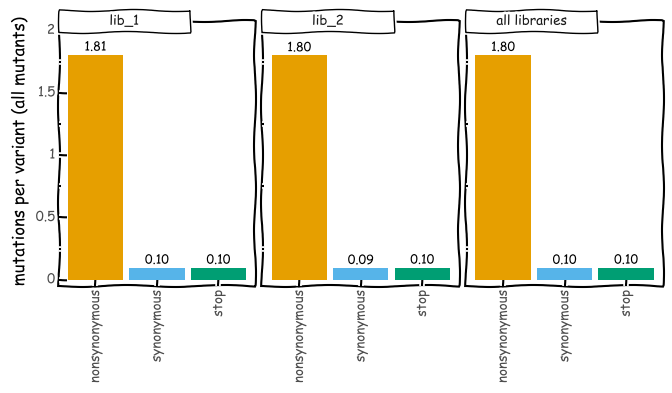

In [61]:
theme_set(theme_xkcd())
p = variants.plotNumCodonMutsByType('all',
                                    samples=None,
                                    heightscale=1.5,
                                    widthscale=1.5)
_ = p.draw()

Note how the above call also used the `heightscale` and `widthscale` options
(which exist for all plotting methods of a
[CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable))
to make the plot larger.

You can also set the orientation differently with
`orientation`, and rename samples with `sample_rename`:

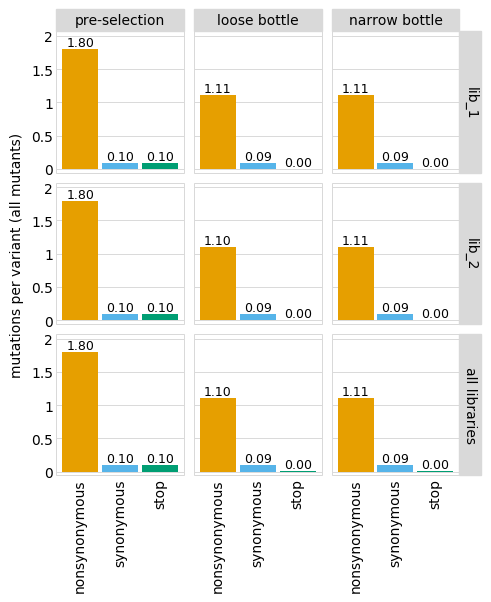

In [62]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

p = variants.plotNumCodonMutsByType('all',
                                    samples='all',
                                    orientation='v',
                                    heightscale=1.2,
                                    sample_rename={'loose_bottle': 'loose bottle',
                                                   'tight_bottle': 'narrow bottle'})
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

Or only show some of the facets.
For instance, just show the individual
libraries:

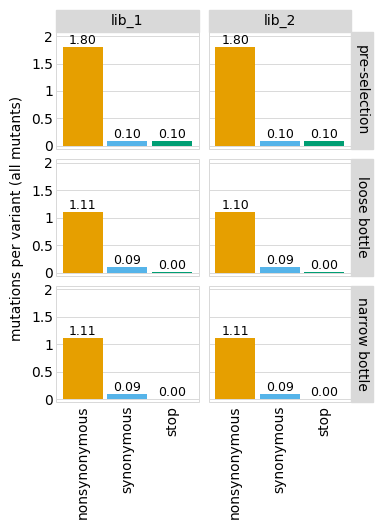

In [63]:
p = variants.plotNumCodonMutsByType('all',
                                    samples='all',
                                    libraries=variants.libraries,
                                    sample_rename={'loose_bottle': 'loose bottle',
                                                   'tight_bottle': 'narrow bottle'})
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()


Or only the merge of all libraries:

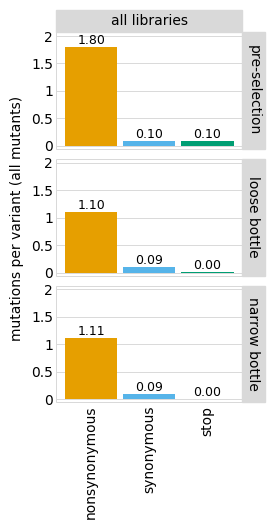

In [64]:
p = variants.plotNumCodonMutsByType('all',
                                    samples='all',
                                    libraries='all_only',
                                    sample_rename={'loose_bottle': 'loose bottle',
                                                   'tight_bottle': 'narrow bottle'})
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

Or only show some samples:

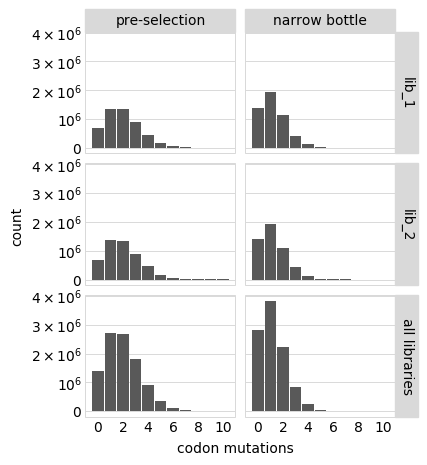

In [65]:
p = variants.plotNumMutsHistogram(mut_type='codon',
                                  samples=['pre-selection', 'tight_bottle'],
                                  orientation='v',
                                  sample_rename={'loose_bottle': 'loose bottle',
                                                 'tight_bottle': 'narrow bottle'})
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

You can also save the plots to image files using their `save` method.
Here we
show how to do this, saving the plot as a PNG to a temporary file and then
displaying that PNG:

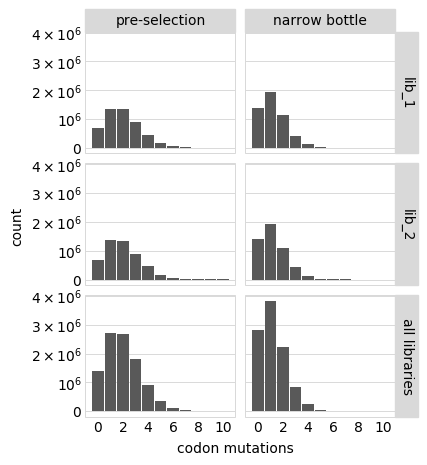

In [66]:
with tempfile.NamedTemporaryFile(suffix='.png') as f:
    p.save(f.name)
    display(Image(f.name))